In [45]:
# Importing packages and ignoring warnings 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# Importing datasets and reading them through pandas package
color = sns.color_palette()
test_url = "https://raw.githubusercontent.com/artemedius/repo/main/houseprice%20forecast/test.csv"
train_url = "https://raw.githubusercontent.com/artemedius/repo/main/houseprice%20forecast/train.csv"
test = pd.read_csv(test_url)
train = pd.read_csv(train_url)

# Saving Id column and deleting from dataframes, they're irrelevant for regression
train_id = train['Id']
test_id = test['Id']
train = train.drop("Id", axis = 1)
test = test.drop("Id", axis = 1)

In [46]:
num_feats = train.dtypes[train.dtypes !='object'].index
skew_feats = train[num_feats].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skew_feats})
print(skewness)

                    Skew
MiscVal        24.476794
PoolArea       14.828374
LotArea        12.207688
3SsnPorch      10.304342
LowQualFinSF    9.011341
KitchenAbvGr    4.488397
BsmtFinSF2      4.255261
ScreenPorch     4.122214
BsmtHalfBath    4.103403
EnclosedPorch   3.089872
MasVnrArea      2.669084
OpenPorchSF     2.364342
LotFrontage     2.163569
SalePrice       1.882876
BsmtFinSF1      1.685503
WoodDeckSF      1.541376
TotalBsmtSF     1.524255
MSSubClass      1.407657
1stFlrSF        1.376757
GrLivArea       1.366560
BsmtUnfSF       0.920268
2ndFlrSF        0.813030
OverallCond     0.693067
TotRmsAbvGrd    0.676341
HalfBath        0.675897
Fireplaces      0.649565
BsmtFullBath    0.596067
OverallQual     0.216944
MoSold          0.212053
BedroomAbvGr    0.211790
GarageArea      0.179981
YrSold          0.096269
FullBath        0.036562
GarageCars     -0.342549
YearRemodAdd   -0.503562
YearBuilt      -0.613461
GarageYrBlt    -0.649415


Most of the data is positively skewed, and if we find this is a linear model, we can transform it later on to make them more normally distributed.

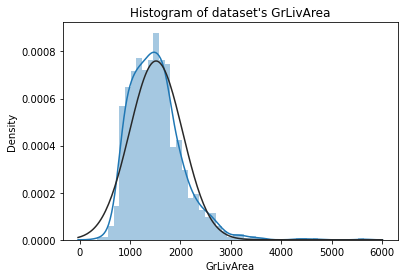

Skewness: 1.366560
Kurtosis: 4.895121


In [47]:
# Defining histogram plot function for visualising distribution of various attributes of dataset
def hist_and_stats(x):
    sns.distplot(train[x], fit=norm)
    plt.title(f"Histogram of dataset's {x}")
    plt.show()
    print("Skewness: %f" % train[x].skew())
    print("Kurtosis: %f" % train[x].kurt())
hist_and_stats('GrLivArea')

Great Living Area is positively skewed, shows peakedness, therefore, deviates from normal distribution.
So, there must be outliers that we can eliminate.

In [48]:
# Detecting outliers
def detect_outlier(df):
    threshold=3.5
    # Playing around with the threshold, I found 3.5 eliminates key outliers,
    # We don't want to eliminate too many either, could hurt more rather than help.
    mean = np.mean(df)
    std = np.std(df)

    outliers=[]
    for y in df:
        z_score= (y - mean)/std 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers
outliers = detect_outlier(train['GrLivArea'])
outlier_df = pd.DataFrame(train[train['GrLivArea'].isin(outliers)])

Outliers highlighted in orange: [3608, 3493, 4676, 3395, 4316, 3627, 4476, 3447, 5642]


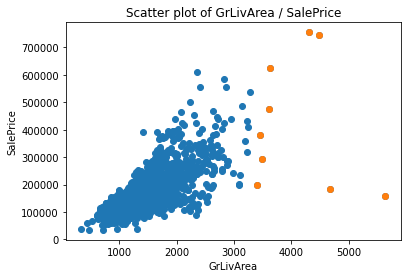

In [49]:
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
ax.scatter(x=outlier_df['GrLivArea'], y=outlier_df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')
plt.title('Scatter plot of GrLivArea / SalePrice')
print(f'Outliers highlighted in orange: {outliers}')
plt.show()

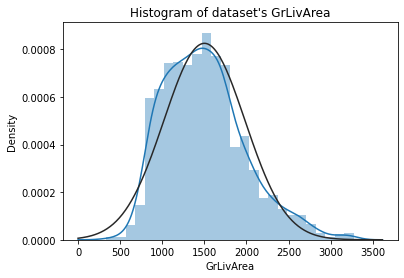

Skewness: 0.703863
Kurtosis: 0.459739


In [50]:
train = train[~train['GrLivArea'].isin(outliers)] # Eliminating outliers from dataset
hist_and_stats('GrLivArea')

Skewness and kurtosis have decreased significantly, but histogram still shows positive skewness.<br> 
<b>We can say GrLivArea and SalePrice have a linear relationship</b>, but what about others?

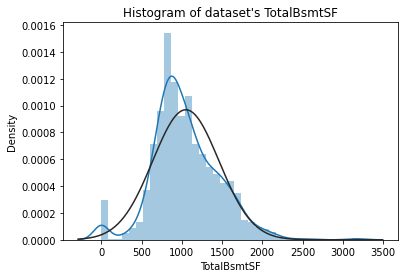

Skewness: 0.488590
Kurtosis: 1.769565


In [51]:
hist_and_stats('TotalBsmtSF')

Outliers highlighted in orange: [3206, 3094, 3200, 2524, 2633]


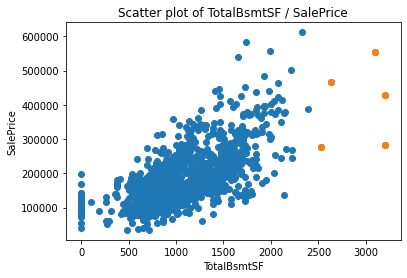

In [52]:
outliers = detect_outlier(train['TotalBsmtSF'])
outlier_df = pd.DataFrame(train[train['TotalBsmtSF'].isin(outliers)])
fig, ax = plt.subplots()
ax.scatter(x=train['TotalBsmtSF'], y=train['SalePrice'])
ax.scatter(x=outlier_df['TotalBsmtSF'], y=outlier_df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('TotalBsmtSF')
plt.title('Scatter plot of TotalBsmtSF / SalePrice')
print(f'Outliers highlighted in orange: {outliers}')

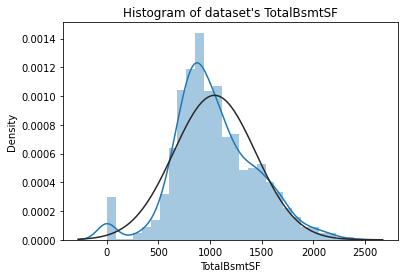

Skewness: 0.201380
Kurtosis: 0.556266


In [53]:
train = train[~train['TotalBsmtSF'].isin(outliers)] # Eliminating outliers from dataset
hist_and_stats('TotalBsmtSF')

***
Total Basement Feet is still positively skewed, but looks better. <br>
Sometimes outliers are the most vital in the dataset, so removing outliers is risky, especially if testing data also contains outliers. However, we need to, since machine learning models are sensitive to them. There could be more outliers, but we don't want to eliminate too many because we want to keep some statistical variability. <br>
#### Now let's look at the target variable!
***

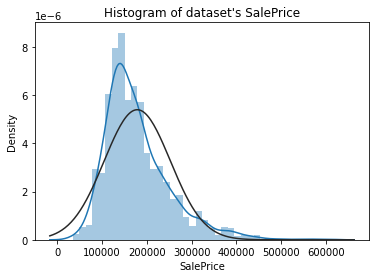

Skewness: 1.446074
Kurtosis: 3.286537


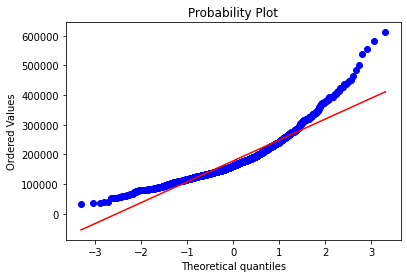

In [54]:
hist_and_stats('SalePrice')
prob_plot = stats.probplot(train['SalePrice'], plot=plt)

SalePrice is also positively skewed, what a surprise 😆 <br> 
#### Let's do a log transformation!

Skewness: 0.016622
Kurtosis: 0.636829


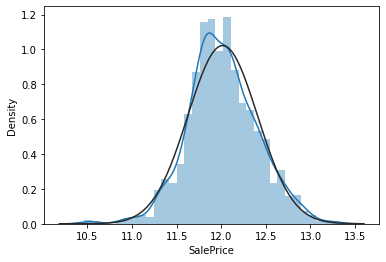

In [55]:
train['SalePrice'] = np.log(train['SalePrice'])
sns.distplot(train['SalePrice'], fit=norm)
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Much better.<br> 
##### Let's move on to feature engineering!

In [56]:
df = pd.concat((train, test)).reset_index(drop=True)
df.drop(['SalePrice'], axis=1, inplace=True)

na_df = (df.isnull().sum() / len(df)*100).sort_values(ascending=False)
na_df = pd.DataFrame({'NA %':na_df})
na_df.head(8)

,NA %
PoolQC,99.724613
MiscFeature,96.385542
Alley,93.218589
Fence,80.481928
FireplaceQu,48.846816
LotFrontage,16.626506
GarageYrBlt,5.438898
GarageFinish,5.438898


<AxesSubplot:>

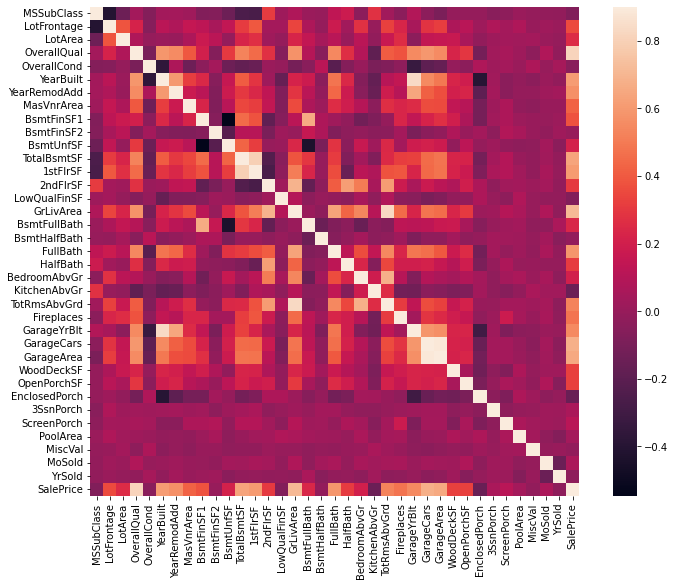

In [57]:
# How features correlate with target variable 'SalePrice'
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)